In this notebook, we compute the runtime for obtaining the pulses when solving the $(\alpha, \beta)$ hypergeometries for different models. For all cases, we repeat the calculation several time, avoiding fluctuations in the CPU times.

First, we solve the LZ problem for several pairs of $(\alpha, \beta)$.

Second, we solve a periodic LZ model, given by the Hamiltonian
$$
\hat{H}_{pLZ}=\cos z(t) \,\sigma_z + x \,\sigma_x.
$$
In this case, we compute the runtime versus the number of anticrossings encountered during the transfer.

Finally, we solve an all-to-all model, where all the states are coupled to each other. The Hamiltonian describing this model reads
$$
 \hat{H}_N = \sum_{k=1}^N \left[(-1)^kz(t)+k\Delta\right]+ x\sum_{k,k'}^N(c_k^\dagger c_{k'} + c_{k'}^\dagger c_k).
$$
The parameters $x,\Delta$ control the size and the position of the anticrossings, $z(t)$ is our control field, and $c_k,c_k^\dagger$ are the annihilation and creation operators, respectively. We compute the adiabatic transfer following the instantaneous eigenstate located in the middle of the band structure. In this case, we only obtain a total of $k_\max$ eigenstates, centered in the eigenstate of interest.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from time import time
from tqdm.auto import tqdm
from scipy.optimize import curve_fit

from HQUAD_lib.QUAD_utils import solve_LZ, compute_x_quad
from HQUAD_lib.plotting_utils import extract_color_map

In [2]:
n_runs = 2  # Increase to get more stable solutions

def run_time(*params):
    times = []
    for i in range(n_runs):
        times.append(_run_time(*params))

    return np.average(times)

# Alpha-beta

In [3]:
def _run_time(alpha, beta):
    t0 = time()
    solve_LZ(alpha, beta, x=x)
    tf = time()
    return tf - t0

In [4]:
x = 1

alphas = np.linspace(-5, 5, 11)  # Increase number of samples to enhance resolution
betas = alphas

pbar = tqdm(total=len(alphas) * len(betas))
times_ab = np.zeros((len(alphas), len(betas)))
for i in range(len(alphas)):
    for j in range(len(betas)):
        times_ab[i, j] = run_time(alphas[i], betas[j])
        pbar.update()
pbar.close()

  0%|          | 0/121 [00:00<?, ?it/s]

# Number of anticrossings

In [22]:
def hamiltonian(z, x):
    t = np.cos(z)
    
    return np.array([[t, x], [x, -t]])

x = 0.1

alpha = 2
beta = 2

In [23]:
def _run_time(n_periods):
    zs = np.linspace(0, 1, 2 ** 15 + 1) * np.pi * n_periods
    partial_hamiltonian = np.array([np.array([[-np.sin(z), 0], [0, np.sin(z)]]) for z in zs])
    
    hypermatrix = np.array([hamiltonian(z, x) for z in zs])
    eigvalues, eigmodes = np.linalg.eigh(hypermatrix)

    t0 = time()

    compute_x_quad(eigvalues, eigmodes, zs, partial_hamiltonian, adiabatic_state=0,
                   alpha=alpha, beta=beta, n_s=2** 15  + 1, limit_inf=1e-2)

    tf = time()
    return tf - t0

In [24]:
times_periods = []
n_periods = np.arange(1, 200)
pbar = tqdm(n_periods)
for i in pbar:
    times_periods.append(run_time(i))

  0%|          | 0/199 [00:00<?, ?it/s]

In [25]:
def line(x, a0, a1):
    return a0 + a1 * x

popt, _  = curve_fit(line, n_periods, np.array(times_periods))

# Multilevel

In [17]:
def hamiltonian(eps: float, shift: float, tau: float, N: int) -> np.ndarray:
    H = np.zeros((N, N))

    for i in range(N):
        H[i, i] = eps * (-1) ** i + shift * i

    H += np.ones((N, N)) * tau - np.eye(N) * tau

    return H

tau = 1
shift = 5

alpha = 2
beta = 2

Ns = np.arange(4, 10)  # Increase to get results for larger systems

In [18]:
def compute_solution(eps_s: np.ndarray, E_0: float, k: int, hypermatrix: np.ndarray, partial_hamiltonian: np.ndarray):
    eigmodes = []
    eigvalues = []
    for i in range(len(eps_s)):
        result = sp.sparse.linalg.eigsh(hypermatrix[i], sigma=E_0, k=k)
        eigvalues.append(result[0])
        eigmodes.append(result[1])

    eigvalues = np.array(eigvalues)
    eigmodes = np.array(eigmodes)

    compute_x_quad(eigvalues, eigmodes, eps_s, partial_hamiltonian,
                   adiabatic_state=k // 2, alpha=alpha, beta=beta)

def _run_time(N: int, k: int):
    E_0 = shift * N / 2  # Energy of the middle
    eps_s = np.linspace(-(N + N * shift / 3), (N + (N + 1) * shift / 3), 2 ** 12 + 1)

    partial_hamiltonian = np.array([hamiltonian(1, 0, 0, N) for _ in range(len(eps_s))])
    hypermatrix = np.array([hamiltonian(eps, shift, tau, N) for eps in eps_s])

    t0 = time()
    compute_solution(eps_s, E_0, k, hypermatrix, partial_hamiltonian)
    tf = time()

    return tf - t0

In [14]:
times_a2a = []

for N in tqdm(Ns, desc='Run in N'):
    times_temp = []
    for k in tqdm(range(3, N), desc='    Run in k', leave=False):
        times_temp.append(run_time(N, k))

    times_a2a.append(times_temp)

Run in N:   0%|          | 0/6 [00:00<?, ?it/s]

    Run in k:   0%|          | 0/1 [00:00<?, ?it/s]

    Run in k:   0%|          | 0/2 [00:00<?, ?it/s]

    Run in k:   0%|          | 0/3 [00:00<?, ?it/s]

    Run in k:   0%|          | 0/4 [00:00<?, ?it/s]

    Run in k:   0%|          | 0/5 [00:00<?, ?it/s]

    Run in k:   0%|          | 0/6 [00:00<?, ?it/s]

# Plots

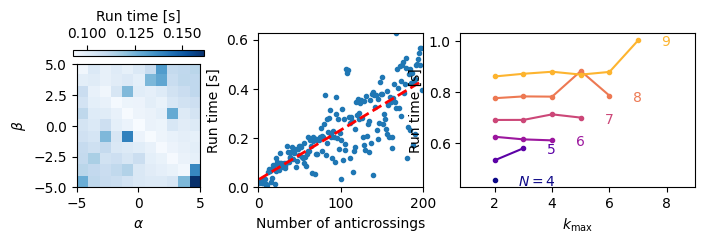

In [27]:
fig, axs = plt.subplot_mosaic('ABC', figsize=(8.25, 2), width_ratios=[0.7, 0.7, 1])
axs = [ax for ax in axs.values()]

# vs. alpha-beta
im = axs[0].imshow(times_ab.T, origin='lower', cmap='Blues',
                   extent=[min(alphas), max(alphas), min(betas), max(betas)])

cbar = plt.colorbar(im, ax=axs[0], label='Run time [s]', location='top', shrink=0.8)
axs[0].set_xlabel(r'$\alpha$')
axs[0].set_ylabel(r'$\beta$')

# vs. Anticrossings
axs[1].plot(n_periods, times_periods, '.', label='Numeric')
axs[1].plot(n_periods, line(n_periods, *popt), 'r--', label=f'Fit', lw=2)

axs[1].set_xlabel('Number of anticrossings')
axs[1].set_ylabel('Run time [s]')
axs[1].set_ylim(0, max(times_periods))
axs[1].set_xlim(0, max(n_periods) + 1)

# vs. num. of states
colors = extract_color_map(len(Ns) + 1, cmap='plasma')

for i in range(len(Ns)):
    color = colors[i]
    xs = np.arange(len(times_a2a[i])) + 2
    axs[2].plot(xs, times_a2a[i], marker='.', color=color)
 
    if i == 0:
        label = f'$N={Ns[i]}$'
    else:
        label = f'${Ns[i]}$'

    axs[2].text(xs[-1] + 0.8, times_a2a[i][-1], label,
                va='center_baseline', ha='left', color=color)
 
axs[2].set_xlim(0.8, max(xs) + 2)

axs[2].set_xlabel(r'$k_\mathrm{max}$')
axs[2].set_ylabel('Run time [s]');